In [1]:
import os
import pickle
import torch
import gc
import h5py

import torch.nn as nn
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scipy.io as sio
import yaml
import sys
import datetime
import scipy.sparse as sps
from collections import defaultdict
from sklearn.preprocessing import normalize
import math

from torch.utils.data import Dataset
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torch.nn.functional as F
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl

# sys.path.insert(0, '../../')
from ACE.preprocessing import HARMONY

In [2]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

def get_matrix(h5seurat_path, matrix): 
    f = h5py.File(h5seurat_path, 'r')
    matrix = f['assays/SCT/' + matrix]
    data = matrix['data']
    indices = matrix['indices']
    indptr = matrix['indptr']
    mx = sps.csr_matrix((data, indices, indptr))
    mx.indices = mx.indices.astype(np.dtype('int64'))
    mx.indptr = mx.indptr.astype(np.dtype('int64'))
    return mx

def transform_adtNames(ad, vardict):
    ad2 = ad.copy()
    var_names = ad2.var_names.to_numpy()
    for k,v in vardict.items():
        if isinstance(k, tuple):
            ad2[:, k[0]].X = ad2[:, k].X.mean(axis=1)
            var_names[np.where(ad2.var_names == k[0])[0]] = v
        else:
            var_names[np.where(ad2.var_names == k)[0]] = v
    ad2.var_names = var_names
    return ad2

def decode_obs(ad, obs=[]):
    ad.obs_names = [_.decode('utf-8') if isinstance(_, bytes) else _ for _ in ad.obs_names]
    for b in obs:
        ad.obs[b] =  [_.decode('utf-8') if isinstance(_, bytes) else _ for _ in ad.obs[b].to_numpy()]
        
def decode_var(ad):
    ad.var_names = [_.decode('utf-8') if isinstance(_, bytes) else _ for _ in ad.var_names.to_numpy()]

In [3]:
# loading RNA atlas
_path = '../../data/COVID-19/RNA-Atlas/yao_2021_processed.HDF5'
with h5py.File(_path, 'r') as f:
    print(f['reductions'].keys())
#     rnaAtlas_norm_data = get_matrix(_path, 'data')
    rnaAtlas_count_data = get_matrix(_path, 'counts')
    rnaAtlas_rna_names = f['assays/SCT/features'][:]

    cell_names = f['cell.names'][:]
    meta_dict = dict()
    for k in f['meta.data'].keys():
        if k != '_index':
            try:
                v = f[f'meta.data/{k}'][:] 
            except:
                v = f[f'meta.data/{k}/values'][:] 
            meta_dict[k] = v 
      
    meta_data = pd.DataFrame(meta_dict, index=f['meta.data']['_index'][:])
    ref_umapReduc = f['reductions']['ref.umap']['cell.embeddings'][:].T
    umap_Reduc = f['reductions']['rna.umap']['cell.embeddings'][:].T
    rnaAtlas_variable_features = (f['assays/SCT/variable.features'])[:]

gex_test = sc.AnnData(rnaAtlas_count_data, obs=meta_data.loc[cell_names])
gex_test.var_names = rnaAtlas_rna_names
gex_test.obsm['original_umap'] = umap_Reduc
gex_test.obsm['ref_umap'] = ref_umapReduc
gex_test.var['highly_variable'] = np.in1d(rnaAtlas_rna_names, rnaAtlas_variable_features) 

del rnaAtlas_count_data
gc.collect()

<KeysViewHDF5 ['pca', 'ref.spca', 'ref.umap', 'rna.umap']>


20

In [4]:
print('=======> loading')
# loading CITE-seq, Seurat 4的CITE-seq
_path = '../../data/COVID-19/Bridge/cite.h5'
with h5py.File(_path, 'r') as f:
    cell_names = np.array(f['cellID'], dtype='S32').astype('str')
    rna_count_data = sps.csc_matrix(
            (np.array(f['RNA.count.data'], dtype=np.float32), 
             np.array(f['RNA.count.indices'], dtype=np.int32),
             np.array(f['RNA.count.indptr'], dtype=np.int32)
            ), 
            shape = np.array(f['RNA.shape'], dtype=np.int32)
    ).tocsc().astype(np.float32).T#.toarray()
    rna_names = np.array(f['rna_names'], dtype='S32').astype('str')
    
    adt_norm_data = np.array(f['adt_norm_data'], dtype=np.float32)
#     adt_count_data = np.array(f['adt_count_data'], dtype=np.float32)
    protein_names = np.array(f['protein_names'], dtype='S32').astype('str')
    
    cite_meta_data = pd.DataFrame(
        dict(
            donor=np.array(f['donor'], dtype='S32').astype('str'),
            celltype_l1=np.array(f['celltype.l1'], dtype='S32').astype('str'),
            celltype_l2=np.array(f['celltype.l2'], dtype='S32').astype('str'),
            celltype_l3=np.array(f['celltype.l3'], dtype='S32').astype('str'),
            Phase=np.array(f['Phase'], dtype='S32').astype('str'),
            X_index=np.array(f['X_index'], dtype='S32').astype('str'),
            lane=np.array(f['lane'], dtype='S32').astype('str'),
            time=np.array(f['time'], dtype='S32').astype('str')
        ),
        index=cell_names
    )
    cite_umap = np.array(f['umap'], dtype=np.float32).T
    
gex = sc.AnnData(rna_count_data, obs=cite_meta_data.loc[cell_names])
gex.var_names = rna_names
other = sc.AnnData(adt_norm_data, obs=cite_meta_data.loc[cell_names])
other.var_names = protein_names
gex.layers['counts'] = gex.X.copy()
gex.obsm['wnn.umap'] = other.obsm['wnn.umap'] = cite_umap

gex.obs['batch'] = gex.obs.donor + '-' + gex.obs.time
other.obs['batch'] = other.obs.donor + '-' + other.obs.time

del rna_count_data, adt_norm_data
gc.collect()
# =========================
# loading RNA atlas
_path = '../../data/COVID-19/RNA-Atlas/yao_2021_processed.HDF5'
with h5py.File(_path, 'r') as f:
    print(f['reductions'].keys())
#     rnaAtlas_norm_data = get_matrix(_path, 'data')
    rnaAtlas_count_data = get_matrix(_path, 'counts')
    rnaAtlas_rna_names = f['assays/SCT/features'][:]

    cell_names = f['cell.names'][:]
    meta_dict = dict()
    for k in f['meta.data'].keys():
        if k != '_index':
            try:
                v = f[f'meta.data/{k}'][:] 
            except:
                v = f[f'meta.data/{k}/values'][:] 
            meta_dict[k] = v 
      
    meta_data = pd.DataFrame(meta_dict, index=f['meta.data']['_index'][:])
    ref_umapReduc = f['reductions']['ref.umap']['cell.embeddings'][:].T
    umap_Reduc = f['reductions']['rna.umap']['cell.embeddings'][:].T
    rnaAtlas_variable_features = (f['assays/SCT/variable.features'])[:]

gex_test = sc.AnnData(rnaAtlas_count_data, obs=meta_data.loc[cell_names])
gex_test.var_names = rnaAtlas_rna_names
gex_test.obsm['original_umap'] = umap_Reduc
gex_test.obsm['ref_umap'] = ref_umapReduc
gex_test.var['highly_variable'] = np.in1d(rnaAtlas_rna_names, rnaAtlas_variable_features) 
gex_test.layers['counts'] = gex_test.X.copy()

del rnaAtlas_count_data
gc.collect()

# ============================
# loading ADT atlas, after down-sampling
_path = '../../data/CYTOF/sel_data.h5'
with h5py.File(_path, 'r') as f:
    cytof_adt_norm_data = np.array(f['norm_data'], dtype=np.float32)
    cytof_umap = np.array(f['umap'], dtype=np.float32)
    cytof_protein_names = np.array(f['protein_names'], dtype='S32').astype('str')

    adt_test_meta = pd.DataFrame(
        dict(
            cytof_sample_id = np.array(f['sample_id'], dtype=np.int16),
            cytof_condition = np.array(f['condition'], dtype=np.int16),
            cytof_patient_id = np.array(f['patient_id'], dtype=np.int16),
            cytof_batch = np.array(f['batch'], dtype=np.int16),
            cytof_combat_id = np.array(f['COMBAT_ID_Time'], dtype='S32').astype('str'),
            cytof_prior = np.array(f['CyTOF_priority'], dtype=np.int16),
            cytof_major_cell_type = np.array(f['major_cell_type'], dtype='S32').astype('str'),
            cytof_fine_cluster_id = np.array(f['fine_cluster_id'], dtype='S32').astype('str')
        ),
        index=np.array(f['cellID'], dtype=np.int32).astype('str')
    )

other_test = sc.AnnData(cytof_adt_norm_data, obs=adt_test_meta)
other_test.var_names = cytof_protein_names

del cytof_adt_norm_data
gc.collect()

# ============================
# process gene names
gex.var_names = [_.upper() for _ in gex.var_names]
gex_test.var_names = [_.decode('utf-8').upper() for _ in gex_test.var_names]
gex.var_names_make_unique()
gex_test.var_names_make_unique()

# processing features names
shared_gene_names = np.intersect1d(
    gex.var_names, 
    gex_test.var_names
)

gex = gex[:, shared_gene_names].copy()
gex_test = gex_test[:, shared_gene_names].copy()

# processing protein names
other.var_names = [_.upper() for _ in other.var_names]
other_test.var_names = [_.upper() for _ in other_test.var_names]
other.var_names_make_unique()
other_test.var_names_make_unique()

var_dict = {
    ('CD3-1', 'CD3-2'): 'CD3',
    ('CD38-1', 'CD38-2'): 'CD38',
    ('CD4-1', 'CD4-2'): 'CD4',
    ('CD45-1', 'CD45-2'): 'CD45',
    ('CD56-1', 'CD56-2'): 'CD56',
    ('CD66A/C/E', 'CD66B'): 'CD66',
    'HLD-DR': 'HLA_DR',
    'IGD': 'IGD_TCRGD',
    'SIGLEC-8': 'SIGLEC_8',
    'TCR-V-7.2' : 'VA7_2'
}

other = transform_adtNames(other, var_dict)

shared_protein_names = np.intersect1d(
    other.var_names, 
    other_test.var_names
)

other = other[:, shared_protein_names].copy()
other_test = other_test[:, shared_protein_names].copy()
assert other.shape[1] == 31, 'incorrect protein features'

decode_obs(gex_test, list(gex_test.obs.columns))
decode_obs(other_test, list(other_test.obs.columns))
decode_var(gex_test)
decode_var(other_test)

=======> loading
<KeysViewHDF5 ['pca', 'ref.spca', 'ref.umap', 'rna.umap']>


In [5]:
log_dir = './checkpoints/yao'

## Visualization for each dataset respectively

bridge-rna dataset

In [6]:
gex.X = gex.layers['counts'].copy()
sc.pp.normalize_total(gex, target_sum=1e4)
sc.pp.log1p(gex)
sc.pp.highly_variable_genes(gex, n_top_genes=5000)
sc.pp.pca(gex, n_comps=50)

In [7]:
gex_df = pd.DataFrame(gex.obsm['X_pca'], index=gex.obs_names.to_numpy())
gex.obsm['dimred'] = HARMONY(gex_df, gex.obs.batch.to_list(), use_gpu=True)

gex = get_umap(gex, use_rep='dimred', add_key='raw_umap')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


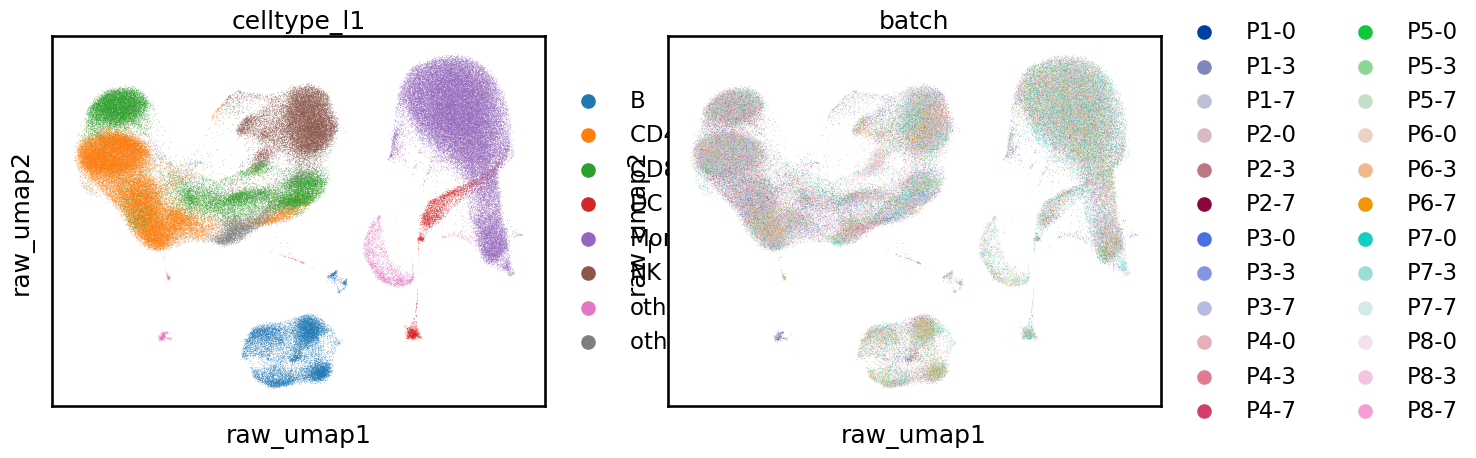

In [8]:
sc.pl.embedding(gex, basis='raw_umap', color=['celltype_l1', 'batch'])

bridge-adt

In [9]:
other_df = pd.DataFrame(other.X, index=other.obs_names.to_numpy())
other.obsm['X_pp'] = HARMONY(other_df, other.obs.batch.to_list(), use_gpu=True)

other = get_umap(other, use_rep='X_pp', add_key='raw_umap')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


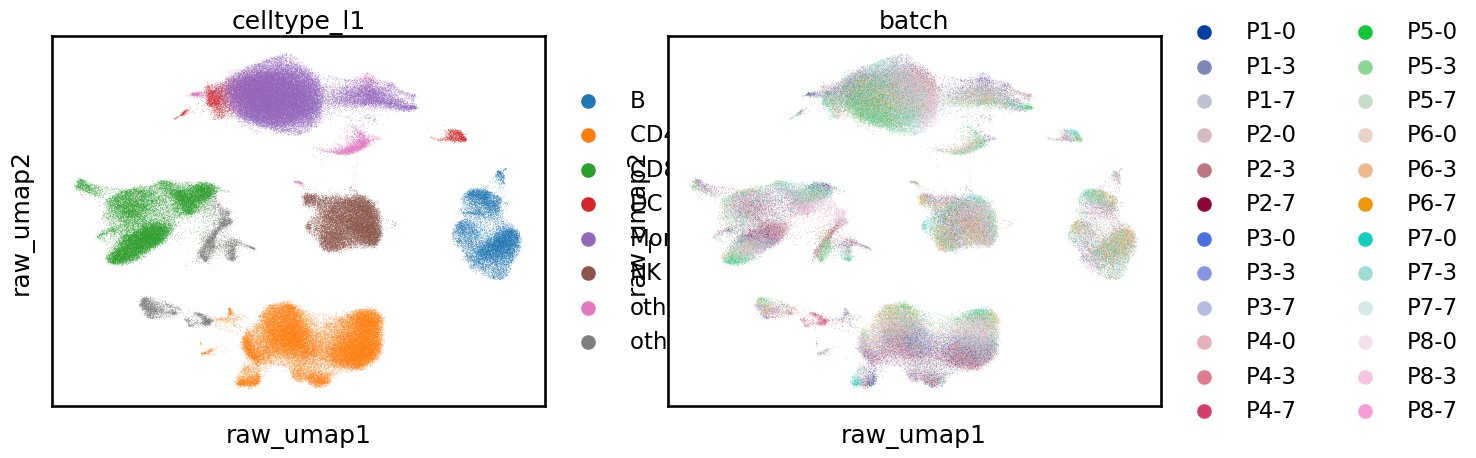

In [10]:
sc.pl.embedding(other, basis='raw_umap', color=['celltype_l1', 'batch'])

bridge-wnn

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


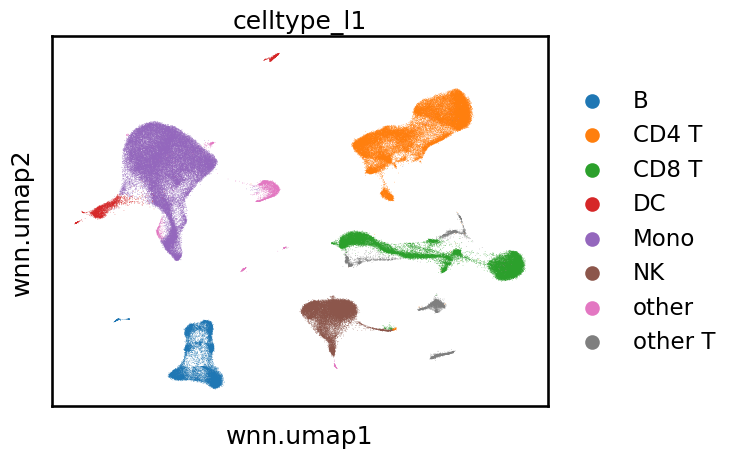

In [11]:
sc.pl.embedding(gex, basis='wnn.umap', color=['celltype_l1'])

COVID19-RNA dataset

In [12]:
gex_test.X = gex_test.layers['counts'].copy()

sc.pp.normalize_total(gex_test, target_sum=1e4)
sc.pp.log1p(gex_test)
sc.pp.highly_variable_genes(gex_test, n_top_genes=5000)
sc.pp.pca(gex_test, n_comps=50)

In [13]:
gex_test_df = pd.DataFrame(gex_test.obsm['X_pca'], index=gex_test.obs_names.to_numpy())
gex_test.obsm['dimred'] = HARMONY(gex_test_df, gex_test.obs['sample'].to_list(), use_gpu=True)

gex_test = get_umap(gex_test, use_rep='dimred', add_key='raw_umap')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


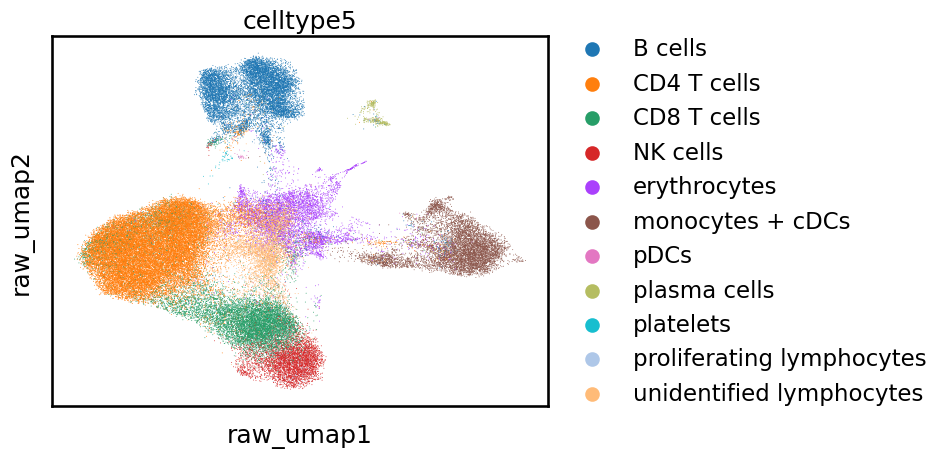

In [14]:
sc.pl.embedding(gex_test, basis='raw_umap', color=['celltype5'])

CYTOF dataset

In [15]:
other_test = get_umap(other_test, use_rep='X', add_key='raw_umap')

In [16]:
_smp_samples = np.random.choice(other_test.obs.cytof_combat_id.unique(), 60, replace=False)
other_test_smp = other_test[other_test.obs.cytof_combat_id.isin(_smp_samples)].copy()
other_test_smp.uns['cytof_combat_id_colors'] = [list(mpl.colors.CSS4_COLORS.keys())[_] for _ in range(60)]

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


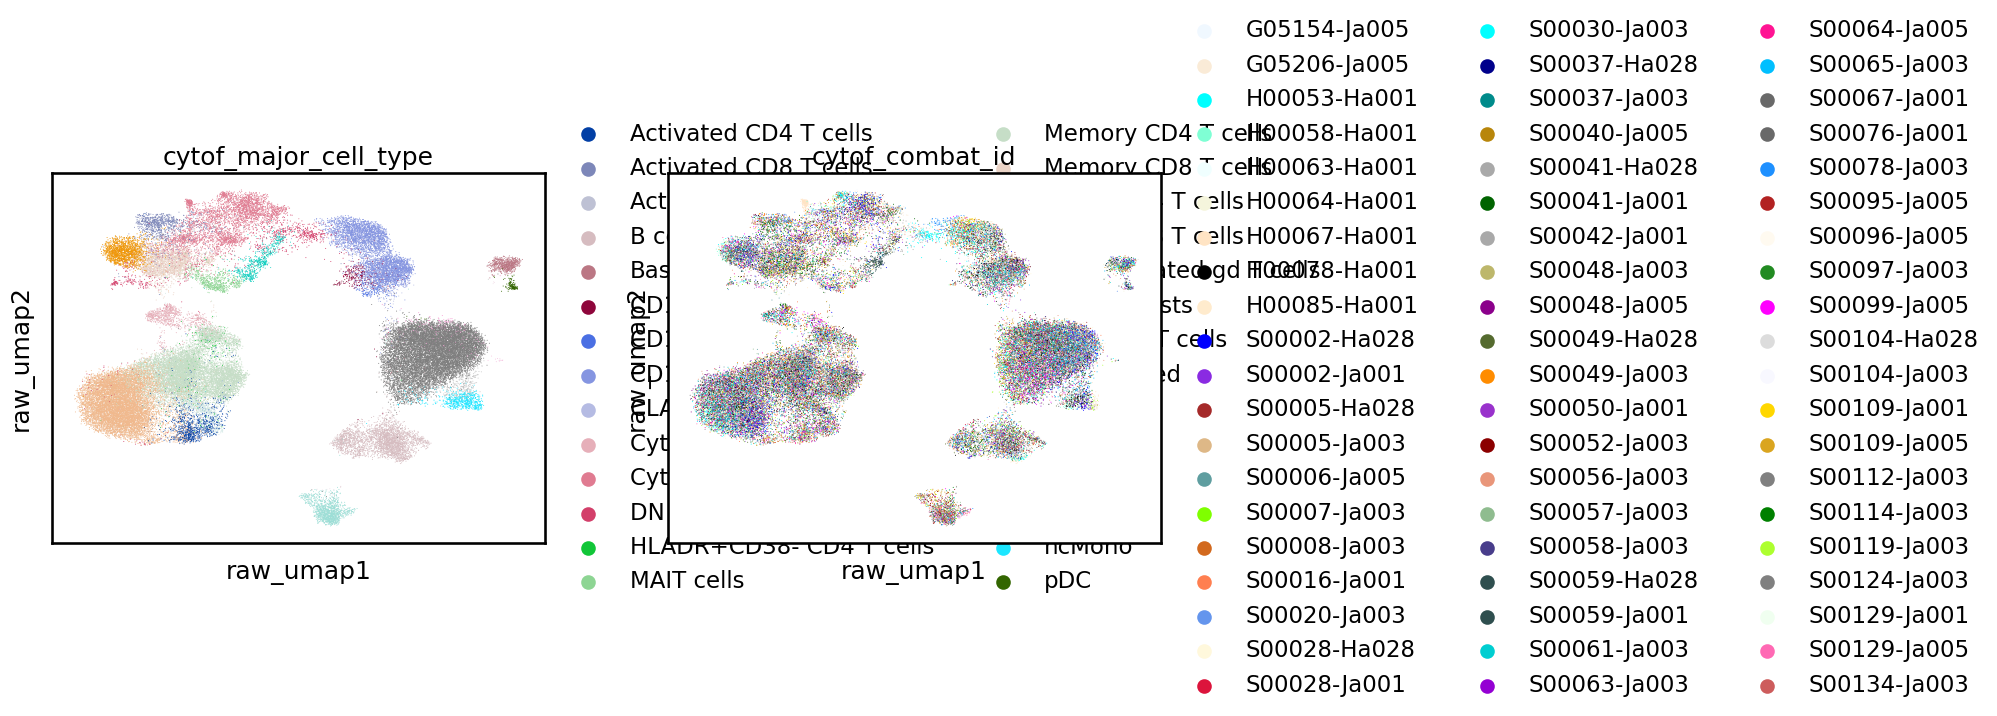

In [17]:
sc.pl.embedding(other_test_smp, basis='raw_umap', color=['cytof_major_cell_type', 'cytof_combat_id'])

### Visualization of embeddings

In [18]:
ad_integ2 = sc.read_h5ad(join(log_dir, 'adata_integ2.h5ad'))
ad_integ2

AnnData object with n_obs × n_vars = 347747 × 128
    obs: 'donor', 'celltype_l1', 'celltype_l2', 'celltype_l3', 'Phase', 'X_index', 'lane', 'time', 'batch', 'age_standard', 'celltype5', 'covid19_standard', 'days_since_hospitalization_estimated_standard', 'days_since_hospitalization_standard', 'days_since_symptom_onset_estimated_standard', 'days_since_symptom_onset_standard', 'disease_severity_standard', 'disease_status_standard', 'group', 'id', 'mapping.score', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'race_reported_standard', 'rna.snn_res.0.8', 'rnaClusterID', 'sample', 'sample_type_note_standard', 'sample_type_standard', 'seurat_clusters', 'sex_standard', 'tissue_standard', 'cytof_sample_id', 'cytof_condition', 'cytof_patient_id', 'cytof_batch', 'cytof_combat_i

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


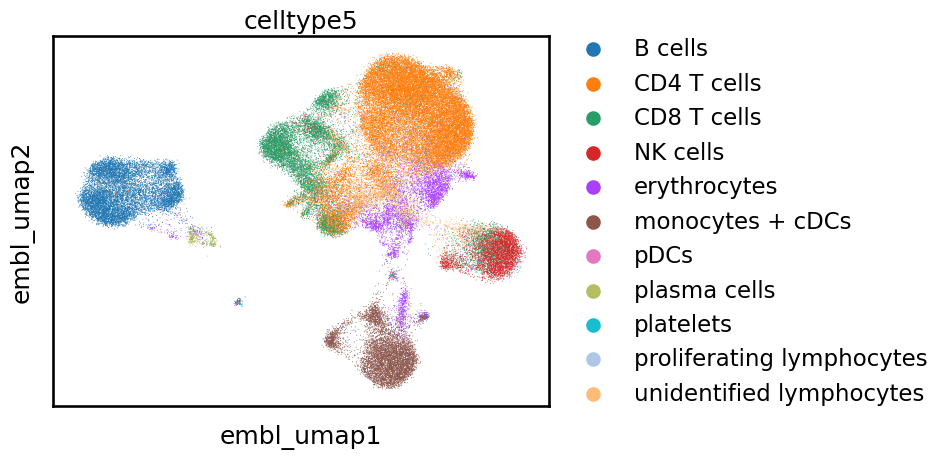

In [19]:
gex_test.obsm['emb'] = ad_integ2[gex_test.obs_names].X.copy()
gex_test = get_umap(gex_test, use_rep='emb', add_key='embl_umap')

sc.pl.embedding(gex_test, basis='embl_umap', color=['celltype5'])

The embeddings are very close to the results in our manuscript. To ensure the consistency of analysis, we provided the version of anndata used in our manuscript

In [20]:
adata_emb_manu = sc.read_h5ad(join(log_dir, 'adata_emb_manuscript.h5ad'))
adata_emb_manu

AnnData object with n_obs × n_vars = 347747 × 128

In [21]:
gex_test.obsm['emb'] = adata_emb_manu[gex_test.obs_names].X.copy()
gex_test = get_umap(gex_test, use_rep='emb', add_key='embl_umap')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


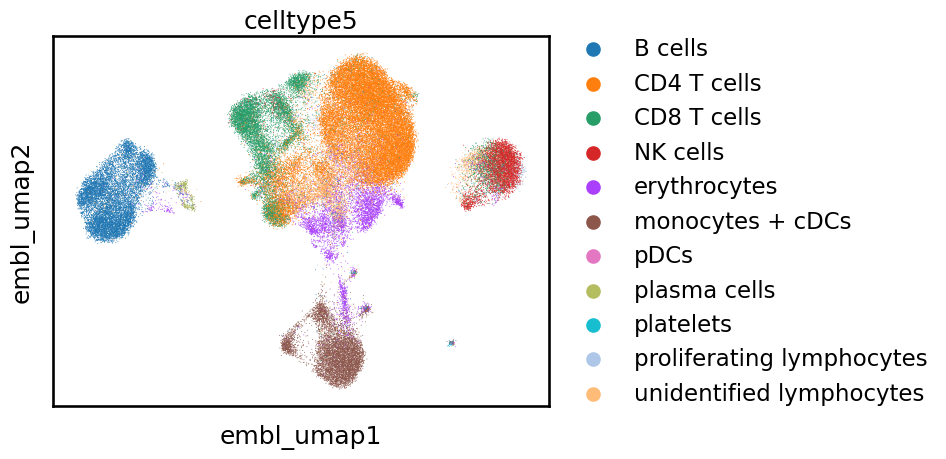

In [22]:
sc.pl.embedding(gex_test, basis='embl_umap', color=['celltype5'])

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


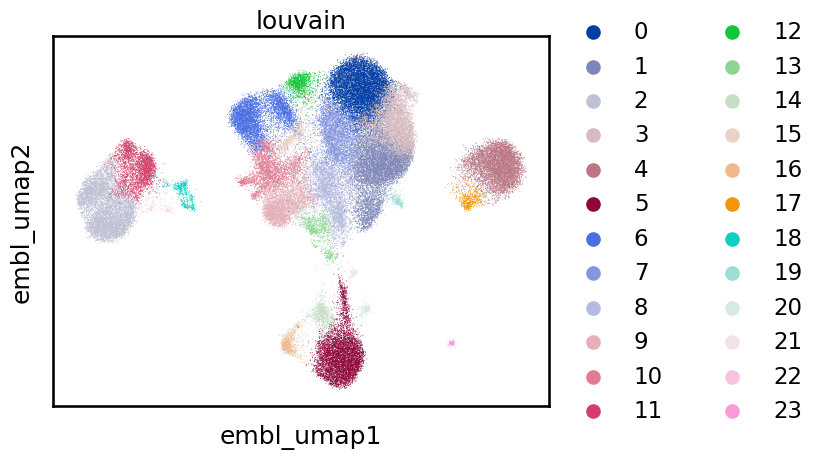

In [23]:
sc.tl.louvain(gex_test, resolution=1.5)
sc.pl.embedding(gex_test, basis='embl_umap', color=['louvain'])

# following the orignal paper
# we removed unidentified lymphocytes cells for further analysis
gex_test_rmUnident = gex_test[gex_test.obs.celltype5!='unidentified lymphocytes'].copy()

### DEG analysis

In [24]:
gex_test_rmUnident.X = gex_test_rmUnident.layers['counts'].copy()
sc.pp.normalize_total(gex_test_rmUnident, target_sum=1e4)
sc.pp.log1p(gex_test_rmUnident)

In [25]:
sc.tl.rank_genes_groups(gex_test_rmUnident, 'louvain', method='wilcoxon')
louvain_15_gene_rank_res = gex_test_rmUnident.uns['rank_genes_groups'].copy()

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

NK cells markers

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))


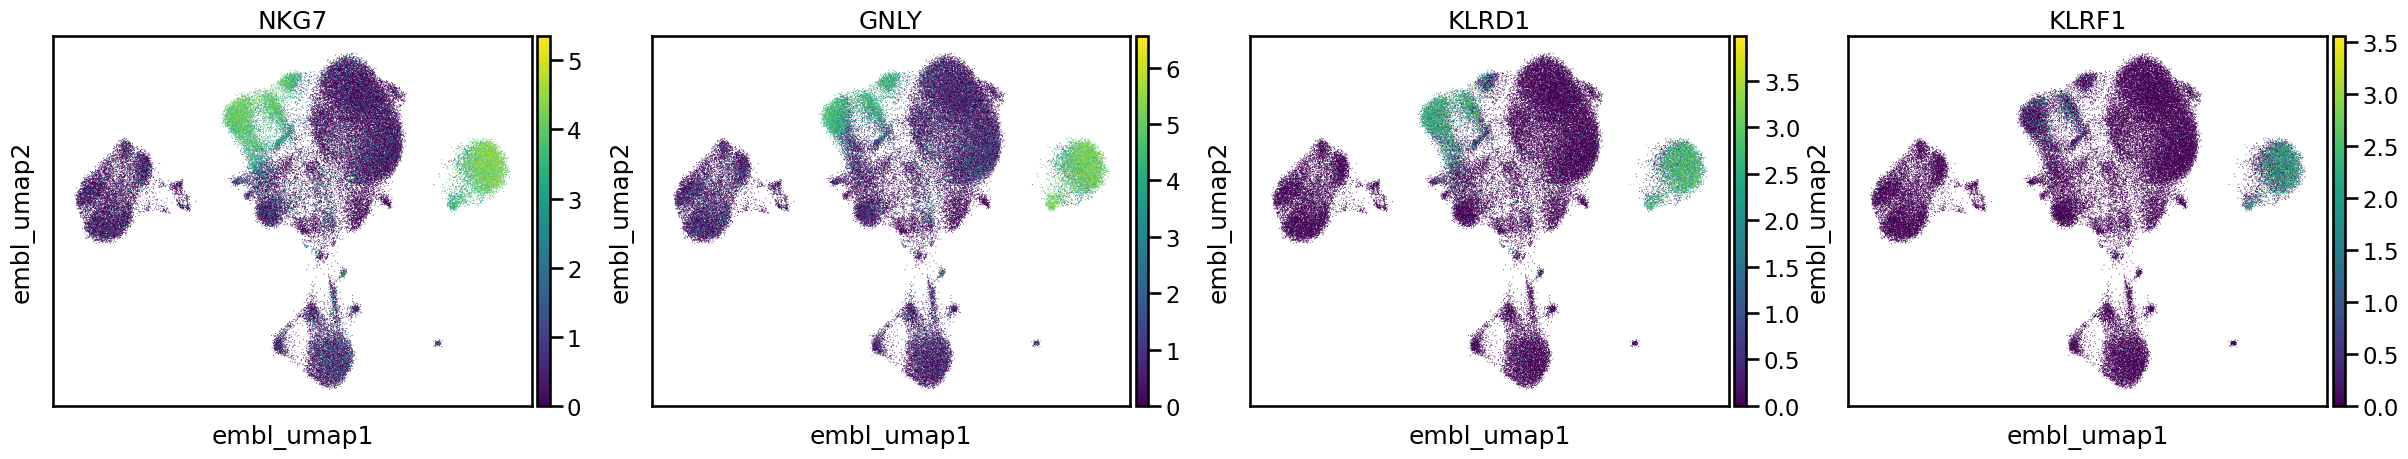

In [26]:
sc.pl.embedding(gex_test_rmUnident, basis='embl_umap', 
                color=['NKG7', 'GNLY', 'KLRD1', 'KLRF1'])

DEGs between NK subpoputations

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


[<AxesSubplot: title={'center': '17 vs. 4'}, xlabel='genes', ylabel='expression'>]

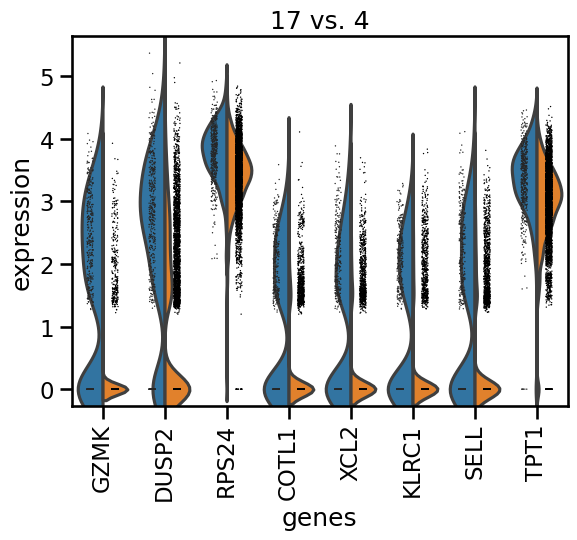

In [27]:
sc.tl.rank_genes_groups(gex_test_rmUnident, 'louvain', groups=['17'], reference='4', method='wilcoxon')
sc.pl.rank_genes_groups_violin(gex_test_rmUnident, groups=['17'], 
#                                gene_names=['GZMK', 'GZMB', 'DUSP2', 'RPS24', 'CST7'],
                               n_genes=8,
                              show=False)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


[<AxesSubplot: title={'center': '17 vs. 4'}, xlabel='genes', ylabel='expression'>]

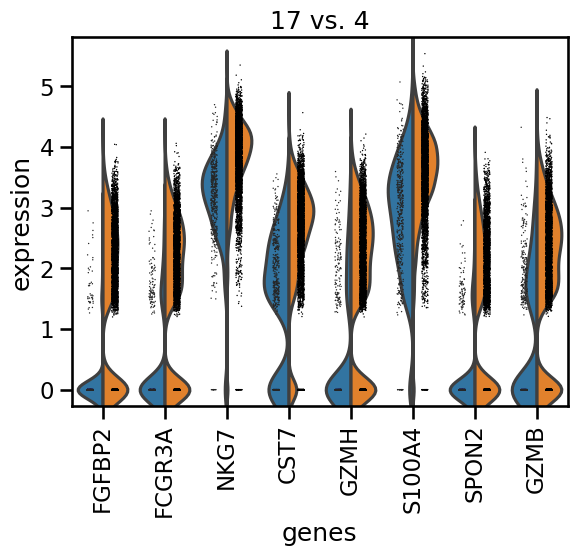

In [28]:
sc.tl.rank_genes_groups(gex_test_rmUnident, 'louvain', groups=['17'], reference='4', method='wilcoxon')
sc.pl.rank_genes_groups_violin(gex_test_rmUnident, groups=['17'], 
                               gene_names=['FGFBP2', 'FCGR3A', 'NKG7', 'CST7', 'GZMH', 'S100A4', 'SPON2', 'GZMB'],
#                                n_genes=10,
                              show=False)

In [29]:
(gex_test_rmUnident[gex_test_rmUnident.obs.louvain=='17'].obs['disease_severity_standard'].value_counts() / (gex_test_rmUnident.obs.louvain=='17').sum()).sort_index()

moderate    0.367556
severe      0.632444
Name: disease_severity_standard, dtype: float64

In [30]:
(gex_test_rmUnident[gex_test_rmUnident.obs.louvain=='4'].obs['disease_severity_standard'].value_counts() / (gex_test_rmUnident.obs.louvain=='4').sum()).sort_index()

moderate    0.434833
severe      0.565167
Name: disease_severity_standard, dtype: float64

Mono + cDC populations

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))


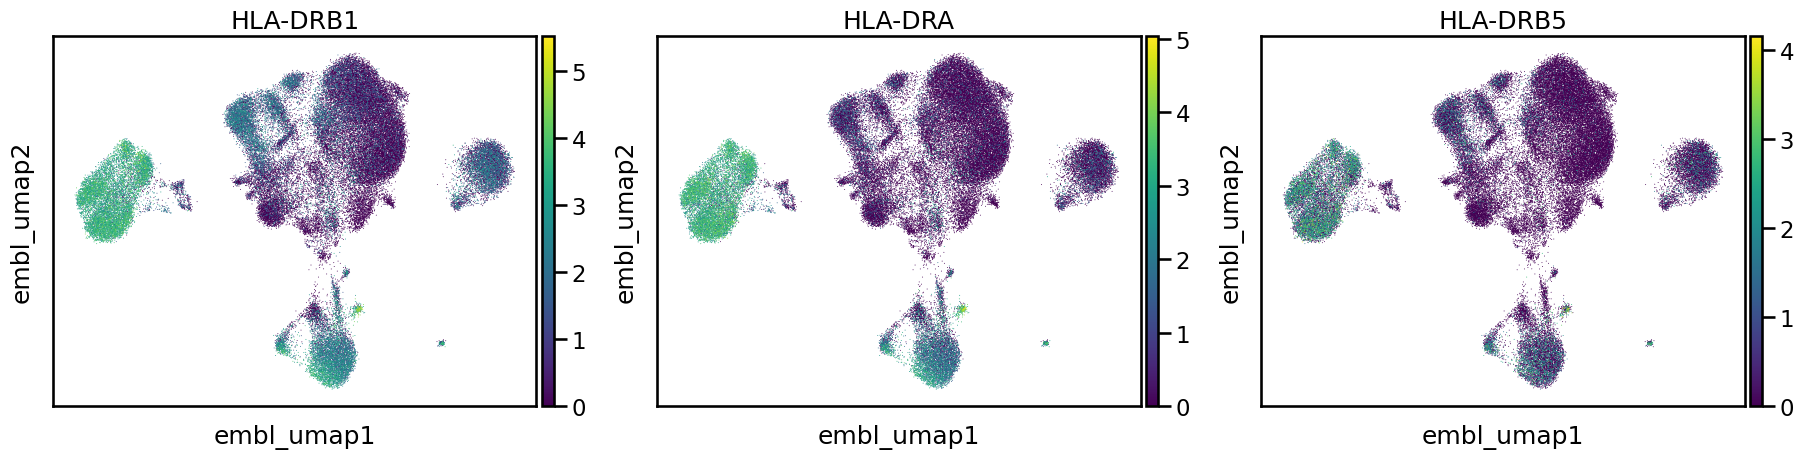

In [31]:
sc.pl.embedding(gex_test_rmUnident, basis='embl_umap', color=
    ['HLA-DRB1', 'HLA-DRA', 'HLA-DRB5'])  # cluster 20: cDC markers
# #     'CDKN1C, FCGR3A, MS4A7, HES4'.split(', ')  # cluster 16: CD16 Mono markers
# #     'S100A8', 'S100A9', 'LYZ', 'CD14',         # cluster 5,14: CD14 Mon markers

CD8 T subpopulations

In [32]:
gex_test_8T = gex_test[
    (gex_test.obs.celltype5!='unidentified lymphocytes') & (gex_test.obs.celltype5.isin(['CD8 T cells'])) 
    & (gex_test.obs.louvain.isin(['6', '9', '10', '12', '13', '15'])) 
    & (gex_test.obsm['embl_umap'][:, 0] <= 12)
].copy()

sc.pp.neighbors(gex_test_8T, n_neighbors=15, use_rep='emb')
sc.tl.louvain(gex_test_8T, resolution=0.3)
gex_test_8T.obs['louvain_8T'] = [f'8T_{_}' for _ in gex_test_8T.obs['louvain']]

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


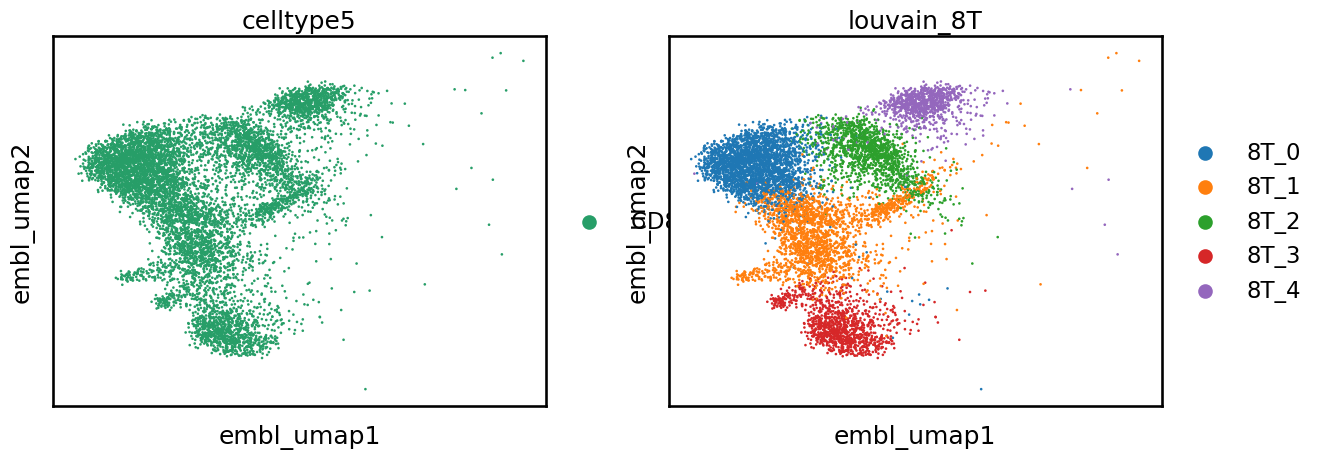

In [33]:
sc.pl.embedding(gex_test_8T, basis='embl_umap', color=['celltype5', 'louvain_8T'])

In [34]:
gex_test_rmUnident.obs['louvain_8TRefine'] = [
    gex_test_8T.obs.loc[_, 'louvain_8T'] 
    if _ in gex_test_8T.obs_names else 
    gex_test_rmUnident.obs.loc[_, 'louvain']
    for _ in gex_test_rmUnident.obs_names
]

sc.tl.rank_genes_groups(gex_test_rmUnident, 'louvain_8TRefine', method='wilcoxon')
louvain_8TRefine_gene_rank_res = gex_test_rmUnident.uns['rank_genes_groups'].copy()

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

In [35]:
# show DEG results for each CD8 T subpopulation
obj = gex_test_rmUnident

for c in [9+4]:  # 9 + {0, 1, 2, 3, 4} indicate: CD8T_{0, 1, 2, 3, 4}
    target_cluster = c
    cluster_target_marker, scores = [], []
    for i in range(obj.shape[1]):
        cluster_target_marker.append(
            louvain_8TRefine_gene_rank_res['names'][i][target_cluster]
        )
        scores.append(
            louvain_8TRefine_gene_rank_res['pvals'][i][target_cluster]
        )
    cluster_target_marker, scores = np.asarray(cluster_target_marker), np.asarray(scores)
    c2s = dict(zip(cluster_target_marker, scores))

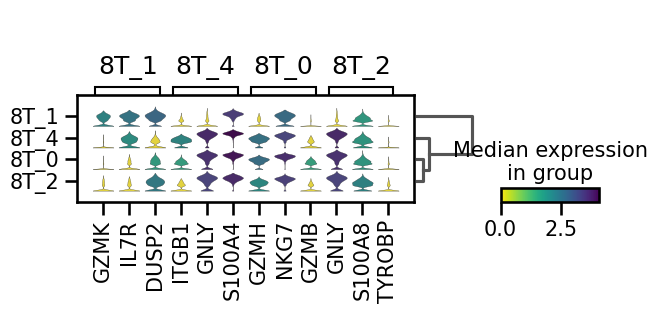

In [37]:
with plt.rc_context():  
    gex_test_rmUnident_8T = gex_test_rmUnident[gex_test_rmUnident.obs.louvain_8TRefine.isin(['8T_0', '8T_1', '8T_2', '8T_4'])].copy()
    gex_test_rmUnident_8T = gex_test_rmUnident_8T[:, gex_test_rmUnident_8T.var_names!='CD8A'].copy()
    gex_test_rmUnident_8T = gex_test_rmUnident_8T[:, gex_test_rmUnident_8T.var_names!='CD8B'].copy()
    sc.tl.rank_genes_groups(gex_test_rmUnident_8T, 'louvain_8TRefine', method='wilcoxon') 

    sc.pl.rank_genes_groups_stacked_violin(gex_test_rmUnident_8T, 
                                           groupby='louvain_8TRefine', 
                                           n_genes=3, cmap='viridis_r', show=False)

In [38]:
# group compositions
obj = gex_test_rmUnident[gex_test_rmUnident.obs.louvain_8TRefine.isin(['8T_0', '8T_1', '8T_2', '8T_4'])].copy()
pd.crosstab(obj.obs.louvain_8TRefine, obj.obs['disease_severity_standard']) / obj.obs.louvain_8TRefine.value_counts().values.reshape(-1, 1)

disease_severity_standard  moderate    severe
louvain_8TRefine                             
8T_0                       0.473924  0.526076
8T_1                       0.369417  0.630583
8T_2                       0.441942  0.558058
8T_4                       0.484780  0.515220

### enhanced representation on bridge dataset

In [39]:
gex.obsm['emb'] = adata_emb_manu[gex.obs_names].X.copy()
gex = get_umap(gex, use_rep='emb')

In [40]:
gex_8T = gex[gex.obs.celltype_l1=='CD8 T'].copy()
sc.pp.neighbors(gex_8T, use_rep='emb', n_neighbors=15)
sc.tl.louvain(gex_8T, resolution=1.)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


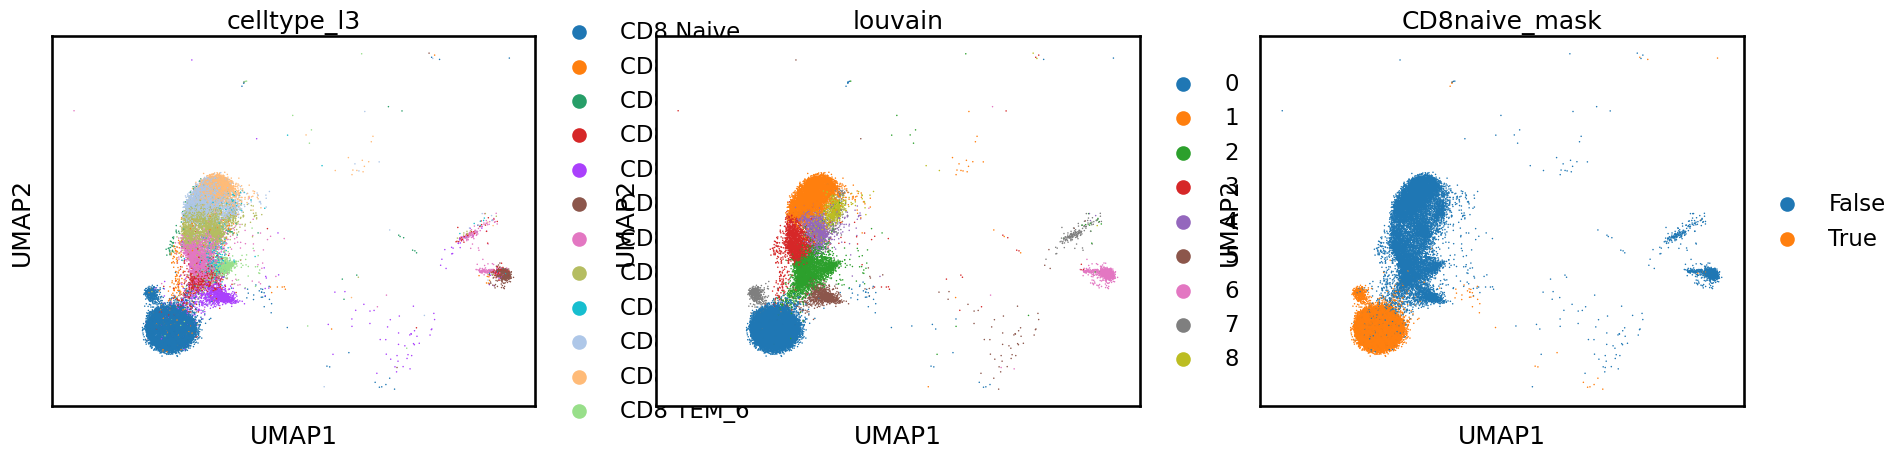

In [41]:
gex_8T.obs['CD8naive_mask'] = (gex_8T.obs.celltype_l3=='CD8 Naive').astype('str')
sc.pl.umap(gex_8T, color=['celltype_l3', 'louvain', 'CD8naive_mask'])

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


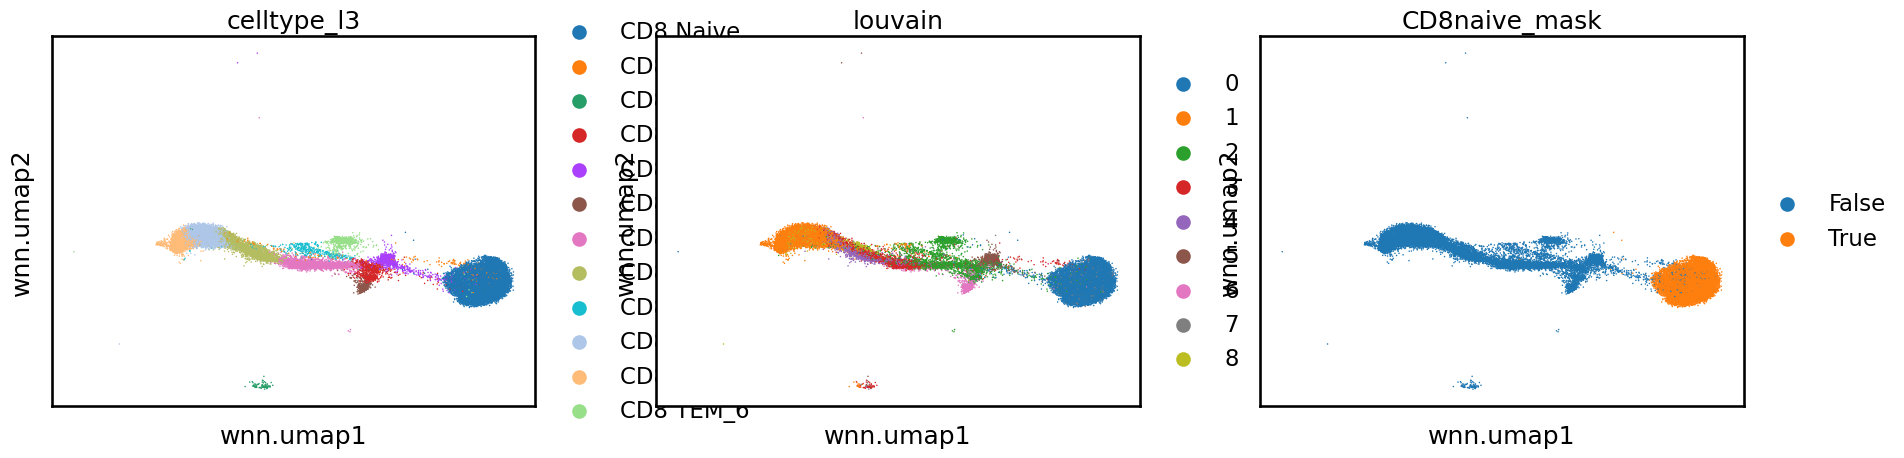

In [42]:
# wnn umap
sc.pl.embedding(gex_8T, basis='wnn.umap', color=['celltype_l3', 'louvain', 'CD8naive_mask'])

In [43]:
# refine the level-3 cluster labels
tmp = gex_8T.obs.celltype_l3.to_numpy()
tmp[gex_8T.obs.louvain=='7'] = 'CD8 Naive_3'
gex_8T.obs['8T_refine'] = tmp

In [44]:
(gex_8T.obs['8T_refine']=='CD8 Naive_3').sum(), (gex_8T.obs['8T_refine']=='CD8 Naive').sum()

(742, 10052)

In [45]:
# introduce MAIT cells
gex_MAIT = gex[gex.obs.celltype_l2.isin(['MAIT'])].copy()
gex_MAIT.obs['8T_refine'] = gex_MAIT.obs['celltype_l3'].to_numpy()
gex_8T_MAIT = sc.concat([gex_8T, gex_MAIT])

In [46]:
# sc.pp.normalize_total(gex_8T_MAIT, target_sum=1e4)
# sc.pp.log1p(gex_8T_MAIT)

# sc.tl.rank_genes_groups(gex_8T_MAIT, '8T_refine', method='wilcoxon')
# gex_8T_MAIT_refine_generanks = gex_8T_MAIT.uns['rank_genes_groups'].copy()

DE analysis on corresponding protein data

In [47]:
other_8T_MAIT = other[gex_8T_MAIT.obs_names].copy()
other_8T_MAIT.obsm['X_umap'] = gex_8T_MAIT.obsm['X_umap']
other_8T_MAIT.obs['8T_refine'] = gex_8T_MAIT.obs['8T_refine'].to_numpy()
# other_8T_MAIT.obs['mask'] = (other_8T_MAIT.obs.celltype_l3=='CD8 Naive').astype('str')

sc.tl.rank_genes_groups(other_8T_MAIT, '8T_refine', method='wilcoxon')
other_8T_refine_generanks = other_8T_MAIT.uns['rank_genes_groups'].copy()

In [48]:
obj = other_8T_MAIT

for c in [2]:  # 2 => CD8 Naive_3
    target_cluster = c
    cluster_target_marker, scores = [], []
    for i in range(obj.shape[1]):
        cluster_target_marker.append(
            other_8T_refine_generanks['names'][i][target_cluster]
        )
        scores.append(
            other_8T_refine_generanks['pvals'][i][target_cluster]
        )
    cluster_target_marker, scores = np.asarray(cluster_target_marker), np.asarray(scores)
    c2s = dict(zip(cluster_target_marker, scores))

In [49]:
c2s  # TCRVα7_2 is the most upregulated protein in cluster 7 (CD8 Naive_3) 

{'VA7_2': 0.0,
 'CD27': 5.088769229886841e-14,
 'CD45RA': 7.761254933118814e-13,
 'CD8': 1.3200572453093902e-05,
 'CD28': 0.023866424569637657,
 'CD38': 0.04006167764778076,
 'IGM': 0.04992665892589764,
 'CD127': 0.06840842178226952,
 'IGD_TCRGD': 0.16262695290928975,
 'CD141': 0.3922446466038255,
 'SIGLEC_8': 0.44846617537229705,
 'CD39': 0.5457444603757586,
 'CD66': 0.8867917163514534,
 'CD20': 0.9431345317517668,
 'CD19': 0.9606662286807977,
 'CD14': 0.8379022022015625,
 'CD25': 0.5695331041922461,
 'CD69': 0.5358766272184696,
 'CD11C': 0.3973237793947846,
 'CD123': 0.36834494337953383,
 'CD103': 0.35533225769764853,
 'CD4': 0.2574684651130358,
 'CX3CR1': 0.1179094806561489,
 'CD16': 0.10951172693038147,
 'CD3': 0.005504517487443806,
 'CD45': 0.0005189929864541002,
 'CD56': 1.913995381176911e-05,
 'CD57': 7.682175325431195e-07,
 'CD45RO': 2.994691807464126e-09,
 'CD161': 2.3492315150219495e-11,
 'CD99': 4.3382285200521245e-15}

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))


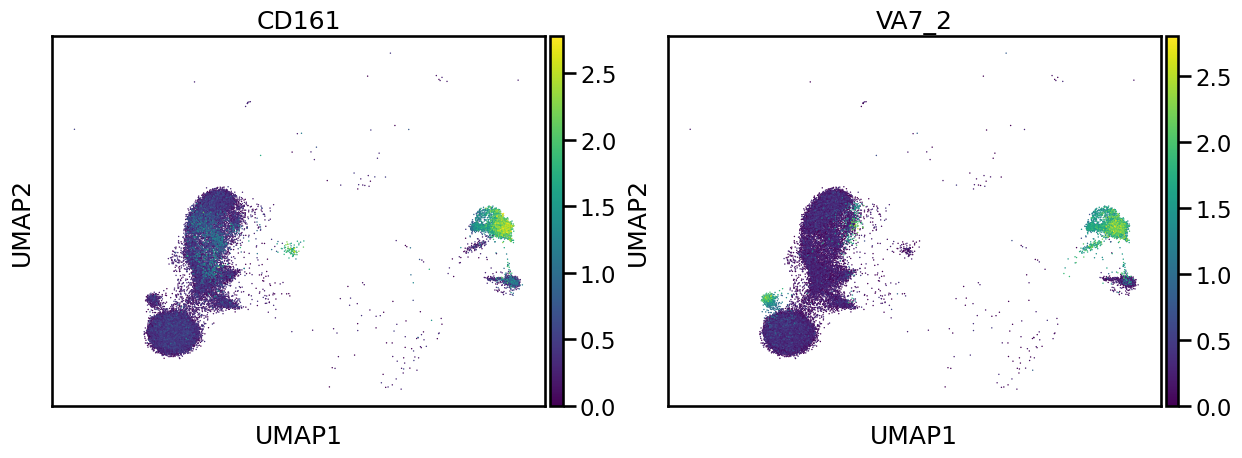

In [50]:
sc.pl.umap(other_8T_MAIT, color=['CD161', 'VA7_2'])